In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np

In [9]:
from wgomoku import GomokuBoard, Heuristics, GomokuTools as gt
from wgomoku import HeuristicGomokuPolicy as HPolicy, ThreatSearch

In [10]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

2.0.0-beta1


True

In [46]:
heuristics = Heuristics(kappa=3.0)
game="j10i9j9j11k10l11h10i10i11h9g8l13k12k9l14g9k11k13i13m13n13e9f9l10j8i6l8i8i7j7k6g10f11l9l12"
stones=gt.string_to_stones(game)
board = GomokuBoard(N=19, stones=stones, disp_width=10, heuristics=heuristics)
p = HPolicy(style = 2, bias=.5, topn=5, threat_search=ThreatSearch(6,5))

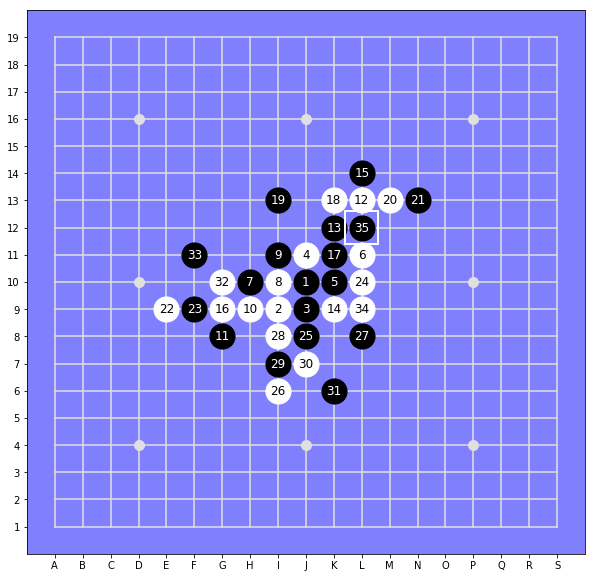

In [47]:
board.display()

In [48]:
move, state = p.most_critical_pos(board), board.game_state()
move, state

(Win-in-2: (K, 8), 1)

#### I'm going to win in two moves. Let's finish it!

In [49]:
board.set(move.x, move.y).game_state()

-1

In [50]:
res = p.most_critical_pos(board)
res

Two or more immediate threats. Giving up.

#### Well, c'mon! Just do it. Get it over with!

In [51]:
clean_scores = board.get_clean_scores(compute_scores=True)
viewpoint = board.current_color
criticals = [
    gt.m2b((r, c),19) 
    for r in range(19) for c in range(19) 
    if clean_scores[viewpoint][r][c] > 7.0]
# is there a better way?
criticals

[array([13, 10]), array([8, 5])]

#### You do one, I do the other, and we both can go home!

In [52]:
for c in criticals:
    board.set(c[0], c[1])

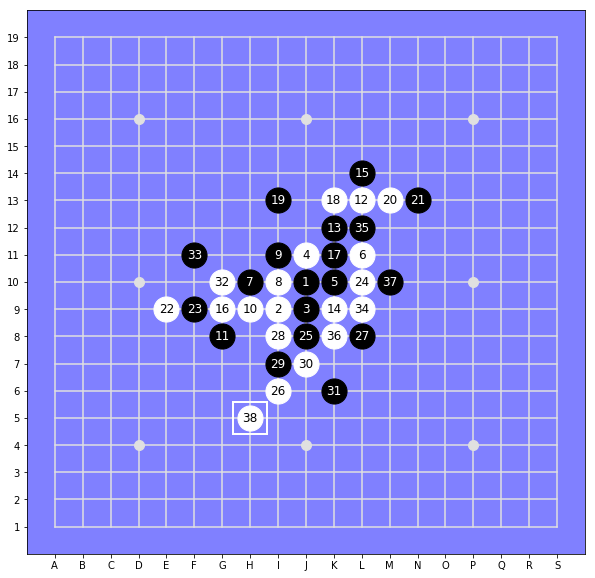

In [53]:
board.display()

In [54]:
from wgomoku import detect5

In [55]:
detect5(board.stones)

array([0., 1.], dtype=float16)

---
So, white wins. Let's look at a black win

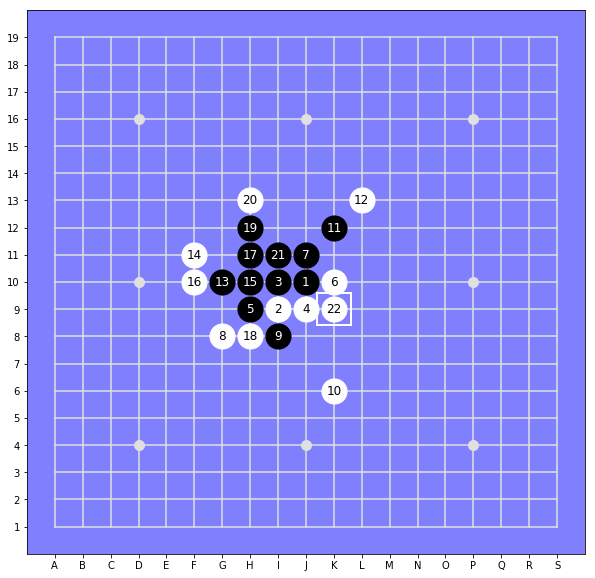

In [56]:
"j10i9i10l10j8g10j7j9k9g13l8m7i11h12k8m8i8h8k6l5"
"j10i9i10h10k7g11f12k9k10l9j9l7l10m10j11j12j7j8i8h7h9g10"
"j10i9k9m7k7i7i10k10h12i11f10g11h10g10h11h13g12j9h9h8f13e14f12e12"
game="j10i9i10j9h9k10j11g8i8k6k12l13g10f11h10f10h11h8h12h13i11k9"
"j10i9i10j9k9m7k10h10l10m10k12k11j11h9l13m14n12m11i12l9h13g14j13h12i13k13i14i11"
stones=gt.string_to_stones(game)
board = GomokuBoard(N=19, stones=stones, disp_width=10, heuristics=heuristics)
board.display()


In [57]:
p.most_critical_pos(board), board.game_state()

(Win-in-2: (K, 11), 1)

In [58]:
board.set(8,15)
p.most_critical_pos(board)

Defending Win-in-2: (K, 11)

In [59]:
def finalize_board(board):
    """
    continues resigned games until a line of 5 is reached. Returns the stones as string
    and the current value, which is obviously always -1
    """
    while (detect5(board.stones) == 0).all():
        #print("not a line of five yet")
        if board.game_state() == 1:
            #print("board should be won for the current player.")
            move = p.most_critical_pos(board)
            board.set (move.x, move.y)
            #print ("Made the next move: (%s, %s)" % (move.x, move.y))
        elif board.game_state() == -1:
            #print("board should be lost for the current player.")            
            clean_scores = board.get_clean_scores(compute_scores=True)
            viewpoint = board.current_color
            criticals = [
                gt.m2b((r, c),19) 
                for r in range(19) for c in range(19) 
                if clean_scores[viewpoint][r][c] > 7.0]
            #print("open 4s: ")
            #print (criticals)
            for c in criticals[:2]:
                board.set(c[0], c[1])
            #print("took the first two. Now there should be a line of 5")
        else:
            return board.stones, 0
            print("Error!")
            print(board.stones)
            raise(ValueError("Shouldn't be here. State is not terminal."))
    return board.stones, -1

In [60]:
import pandas as pd

In [332]:
all_games = pd.read_csv("newgames5.csv", usecols=[0], 
                  header=None, names=['game']).squeeze().tolist()

In [333]:
with open("newgames5_corr.csv", 'w') as output:
    ts=ThreatSearch(3,5)
    errors = []
    n = 0
    for game in all_games[:1000]:
        n += 1
        if n % 100 == 0:
            print(n)
        stones=gt.string_to_stones(game)
        board = GomokuBoard(N=19, stones=stones, disp_width=10, heuristics=heuristics)
        if board.game_state() == 0:
            #print(game)
            (seq, won), _ = ts.is_tseq_won(board)
            if won:
                #print("winning sequence")
                for m in seq:
                    board.set(m[0], m[1])
            else:
                seq, lost = ts.is_tseq_threat(board)
                if lost:
                    #print("losing seqence")
                    move = seq[0]
                    #print("setting (%s, %s)" % move)
                    board.set(move[0], move[1])                    

        if board.game_state() == 0:
            #print("still not terminated")
            final_stones = board.stones
            errors.append((game, stones, final_stones, 0))
        else:
            final_stones, state = finalize_board(board)
            fives = detect5(board.stones)
            if (fives == 0).all():
                errors.append((game, stones, final_stones, state))
            else:
                final_game = gt.stones_to_string(board.stones)
                output.write("%s, %s\n" % (final_game, 'b' if fives[0] else 'w'))

len(errors)

100
200
300
400
500
600
700
800
900
1000


87

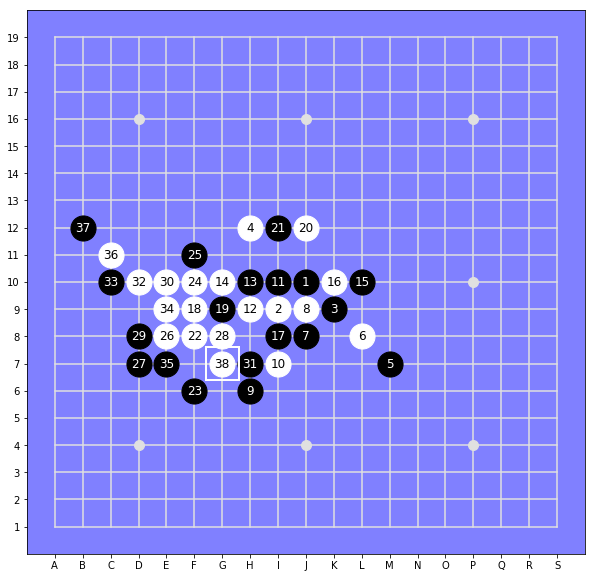

In [327]:
heuristics = Heuristics(kappa=3.0)
game="j10i9k9h12m7l8j8j9h6i7i10h9h10g10l10k10i8f9g9j12i12f8f6f10f11e8d7g8d8e10h7d10c10e9e7c11b12g7"
stones=gt.string_to_stones(game)
board = GomokuBoard(N=19, stones=stones, disp_width=10, heuristics=heuristics)
board.display()